In [1]:
%load_ext autoreload
%autoreload 2

# Figure 3 - Gene Expression

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import colorcet as cc

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
adata_th = abc.load_standard_thalamus(data_structure='adata')

In [4]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [5]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata_th.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [17]:
adata_th_left = adata_th[adata_th.obs['left_hemisphere']].copy()

# Load the CCF structures image - just the left hemisphere
ccf_images_left = abc.get_ccf_labels_image(subset_to_left_hemi=True)

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata_th_left.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries_left = cimg.sectionwise_label_erosion(ccf_images_left, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [6]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names('substructure')

In [13]:
# load the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
abc_palettes['cluster'] = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

In [8]:
results_dir = '../../results'

## Figure 3A

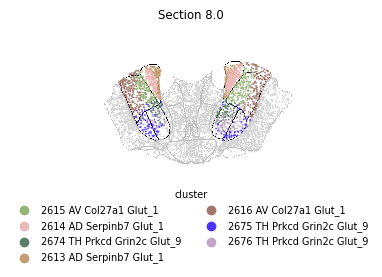

In [14]:
# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=1.5,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver'
    )

# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, adata_th_left.obs)

# Let's look at the cell types in the ATN in one sample section
sections_to_plot = [cplots.TH_EXAMPLE_Z_SECTIONS[0]]
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV', 'AV']
taxonomy_level = 'cluster'

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                    ccf_images,
                                    boundary_img=ccf_boundaries,
                                    bg_cells=adata_th.obs, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)
figs_annot[0].savefig(f'{results_dir}/fig2f_cluster_annotations_z80_ATN.pdf', 
                      transparent=True, bbox_inches='tight')
figs_annot[0].savefig(f'{results_dir}/fig2f_cluster_annotations_z80_ATN.png', 
                      transparent=True, bbox_inches='tight', dpi=1200)

## Figure n_genes? - gene expression dot plot

In [18]:
# kwargs_scatter = dict(
#     linewidths=2,
#     edgecolors='black',
#     )

### ATN nuclei

In [19]:
# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, adata_th.obs)

# clean up cluster categories
obs_annot.loc[:,'cluster'] = obs_annot.loc[:,'cluster'].cat.remove_unused_categories()
# get the nucleus-specific list of clusters
cluster_list_ATN = sorted(obs_annot.loc[:,'cluster'].cat.categories)

# use that list to filter & reset the cluster col in the full anndata object
adata_ATN = adata_th[adata_th.obs['cluster'].isin(cluster_list_ATN)].copy()

adata_ATN.obs.loc[:,'cluster'] = adata_ATN.obs.loc[:,'cluster'].cat.remove_unused_categories()
adata_ATN.obs.loc[:,'cluster'] = adata_ATN.obs.loc[:,'cluster'].cat.reorder_categories(cluster_list_ATN, ordered=True)

In [20]:
supertypes_ATN = ['0642 AV Col27a1 Glut_1', 
                  '0641 AD Serpinb7 Glut_1',
                  '0662 TH Prkcd Grin2c Glut_9']

adata_ATN.obs['supertype'].cat.categories

Index(['0642 AV Col27a1 Glut_1', '0641 AD Serpinb7 Glut_1',
       '0662 TH Prkcd Grin2c Glut_9'],
      dtype='object')

In [21]:
clusters_med_to_lat_ATN = [
    '2613 AD Serpinb7 Glut_1',
    '2614 AD Serpinb7 Glut_1',
    '2615 AV Col27a1 Glut_1',
    '2616 AV Col27a1 Glut_1',
    '2674 TH Prkcd Grin2c Glut_9',
    '2676 TH Prkcd Grin2c Glut_9',
    '2675 TH Prkcd Grin2c Glut_9',
]

# reorder by manual medial-to-lateral ordering
adata_ATN.obs.loc[:,'cluster'] = adata_ATN.obs.loc[:,'cluster'].cat.reorder_categories(clusters_med_to_lat_ATN, ordered=True)

In [22]:
adata_ATN.obs.loc[:,'cluster'].cat.categories

Index(['2613 AD Serpinb7 Glut_1', '2614 AD Serpinb7 Glut_1',
       '2615 AV Col27a1 Glut_1', '2616 AV Col27a1 Glut_1',
       '2674 TH Prkcd Grin2c Glut_9', '2676 TH Prkcd Grin2c Glut_9',
       '2675 TH Prkcd Grin2c Glut_9'],
      dtype='object')

['Adcy2', 'Nptx2', 'Syndig1l', 'C1ql3', 'Nxph1', 'Slc17a7', 'Syndig1l', 'Scn4b', 'Adcy2', 'Hs3st4', 'Htr1b', 'Zbtb16', 'Col27a1', 'Lhfp', 'Sorcs3', 'Sox2', 'Chrm3', 'Car4', 'Npsr1', 'Lhfp', 'Ramp3', 'Tnnt1', 'Tmem132c', 'Epha4', 'Necab1', 'Calb1', 'Tnnt1', 'Grik1', 'Cbln1', 'Galnt18', 'Calb1', 'Tox', 'Cbln1', 'Stxbp6', 'Tcf7l2']


/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


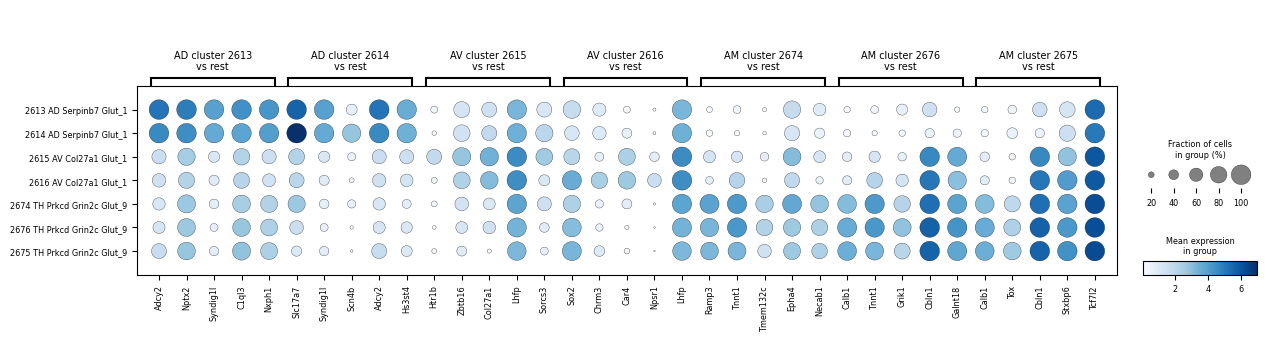

In [23]:
# get top 5 DEGs for each ATN cluster vs rest of the clusters
# TODO: check if DEGs change when you run this analysis on an anndata object 
#       with: the whole brain vs the whole thalamus vs just the ATN cells
deg_list_ATN = []
for cluster in clusters_med_to_lat_ATN:
    sc.tl.rank_genes_groups(adata_ATN, groupby="cluster", groups=[cluster],
                            reference='rest', n_genes=5, method="wilcoxon")
    deg_list_ATN.extend(sc.get.rank_genes_groups_df(adata_ATN, group=cluster).names.to_list())

print(deg_list_ATN)

# manually set gene group labels for dotplot
var_group_positions = [[0,4], [5,9], 
                       [10,14], [15,19], 
                       [20,24], [25,29], [30,34]]
var_group_labels = ['AD cluster 2613\nvs rest', 
                    'AD cluster 2614\nvs rest',
                    'AV cluster 2615\nvs rest', 
                    'AV cluster 2616\nvs rest',
                    'AM cluster 2674\nvs rest', 
                    'AM cluster 2676\nvs rest', 
                    'AM cluster 2675\nvs rest']
# dotplot
sc.pl.dotplot(adata_ATN,
              deg_list_ATN,
            #   sorted(list(set(deg_list_ATN))), 
              groupby='cluster', 
              dendrogram=False,
              cmap='Blues',
              var_group_positions=var_group_positions,
              var_group_labels=var_group_labels,
              var_group_rotation=0)

In [24]:
def get_rank_genes_list(adata, 
                        groupby='cluster', 
                        group='', 
                        reference='rest', 
                        n_genes=5):
    # find DEGs
    sc.tl.rank_genes_groups(adata, 
                            groupby="cluster", 
                            groups=[group],
                            reference=reference, 
                            n_genes=n_genes, 
                            method="wilcoxon")
    # get DEGs
    deg_list = sc.get.rank_genes_groups_df(adata, group=group).names.to_list()
    
    return deg_list

In [25]:
cluster_list_ATN

['2613 AD Serpinb7 Glut_1',
 '2614 AD Serpinb7 Glut_1',
 '2615 AV Col27a1 Glut_1',
 '2616 AV Col27a1 Glut_1',
 '2674 TH Prkcd Grin2c Glut_9',
 '2675 TH Prkcd Grin2c Glut_9',
 '2676 TH Prkcd Grin2c Glut_9']

['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14', 'Epha4', 'Grm1', 'Rorb', 'Kitl', 'Slc17a7']
['Calb2', 'Cnr1', 'Lypd1', 'Glra2', 'Unc13c', 'Scn4b', 'Slc17a7', 'Rgs4', 'Syt2', 'Rorb', 'Grm1', 'Rorb', 'Sorcs3', 'Htr1b', 'Nfib', 'Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14', 'Epha4', 'Grm1', 'Rorb', 'Kitl', 'Slc17a7', 'Pdyn', 'Fbn2', 'Sox2', 'Grik1', 'Rgs6', 'Pdyn', 'Col27a1', 'Tnnt1', 'Grik1', 'Tmem132c']
['Calb2', 'Cnr1'

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


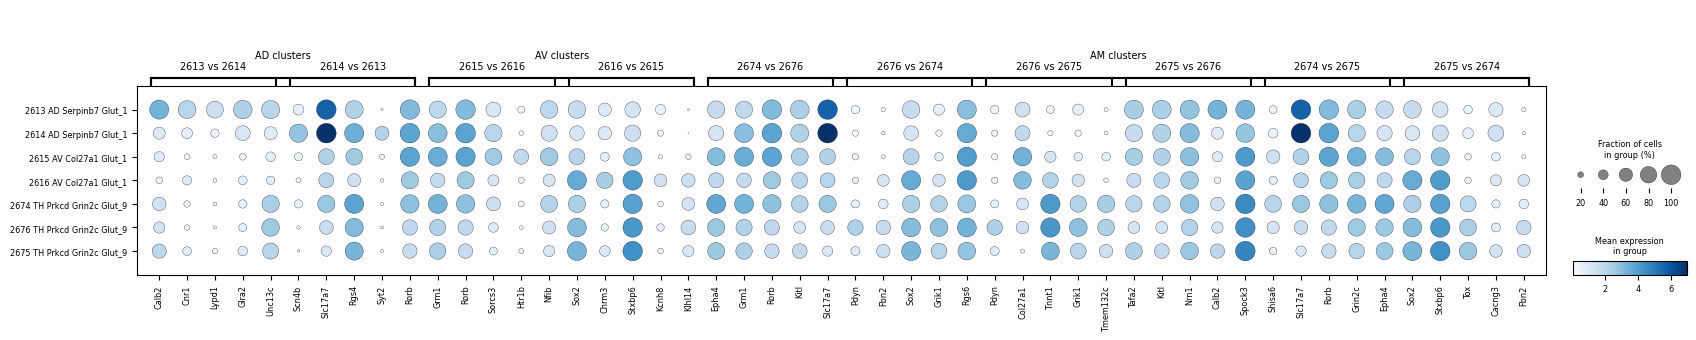

In [26]:
deg_paired_list_ATN = []
n_genes = 5

# AD clusters vs each other
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2613 AD Serpinb7 Glut_1', 
                                               reference='2614 AD Serpinb7 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
# sc.pl.rank_genes_groups(adata_ATN, group=cluster_list_ATN[0])
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2614 AD Serpinb7 Glut_1', 
                                               reference='2613 AD Serpinb7 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)

# AV clusters vs each other
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2615 AV Col27a1 Glut_1',
                                               reference='2616 AV Col27a1 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2616 AV Col27a1 Glut_1',
                                               reference='2615 AV Col27a1 Glut_1',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)

# AM clusters vs each other -- medial -> lateral : 2674 -> 2676 -> 2675
# 2676 vs 2674
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2674 TH Prkcd Grin2c Glut_9', 
                                               reference='2676 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2676 TH Prkcd Grin2c Glut_9', 
                                               reference='2674 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
# 2676 vs 2675
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2676 TH Prkcd Grin2c Glut_9', 
                                               reference='2675 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2675 TH Prkcd Grin2c Glut_9', 
                                               reference='2676 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
# 2674 vs 2675
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2674 TH Prkcd Grin2c Glut_9', 
                                               reference='2675 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)
deg_paired_list_ATN.extend(get_rank_genes_list(adata_ATN, 
                                               group='2675 TH Prkcd Grin2c Glut_9', 
                                               reference='2674 TH Prkcd Grin2c Glut_9',
                                               n_genes=n_genes))
print(deg_paired_list_ATN)

# set gene group labels for dotplot
var_group_positions = [[0,9], [0,4], [5,9], 
                       [10,19], [10,14], [15,19], 
                       [20,49], [20,24], [25,29], [30,34], [35,39], [40,44], [45,49]]
var_group_labels = ['AD clusters\n',
                    '2613 vs 2614',
                    '2614 vs 2613',
                    'AV clusters\n',
                    '2615 vs 2616',
                    '2616 vs 2615',
                    'AM clusters\n',
                    '2674 vs 2676',
                    '2676 vs 2674',
                    '2676 vs 2675',
                    '2675 vs 2676',
                    '2674 vs 2675',
                    '2675 vs 2674']
# dotplot
sc.pl.dotplot(adata_ATN,
              deg_paired_list_ATN, 
              groupby='cluster', 
              dendrogram=False,
              cmap='Blues',
              var_group_positions=var_group_positions,
              var_group_labels=var_group_labels,
              var_group_rotation=0,
              )

In [27]:
# var_group_positions = [[0,4], [5,9], [10,14], [15,19], 
#                        [20,24], [25,29], [30,34], [35,39], [40,44], [45,49]]
# var_group_labels = ['AD clusters\n2613 vs 2614',
#                     'AD clusters\n2614 vs 2613', 
#                     'AV clusters\n2615 vs 2616', 
#                     'AV clusters\n2616 vs 2615',
#                     'AM clusters\n2674 vs 2676',
#                     'AM clusters\n2676 vs 2674',
#                     'AM clusters\n2676 vs 2675',
#                     'AM clusters\n2675 vs 2676',
#                     'AM clusters\n2674 vs 2675',
                    # 'AM clusters\n2675 vs 2674']


In [28]:
gene_list = sorted(adata_ATN.var.index)

In [29]:
# AD markers from literature
nagalski_2016_markers_ad = ['Ahnak2', 
                       'Bcl2l11',
                       'C1ql2',
                       'Col5a2',
                       'Ddef1',
                       'Dkk3',
                       'Ephx2',
                       'Gng13',
                       'Ism1',
                       'Kcng3',
                       'Notum',
                       'Ntn1',
                       'Stard13'
                       ]
roy_2021_markers_ad = ['C1ql2', 'Herc1', 'Mtor', 'Prchd1', 'Ywhag']

nagalski_markers_av = ['Echdc2', 'Myo5c']
roy_2021_markers_av = ['Col25a1']

In [30]:
for gene in nagalski_2016_markers_ad:
    if gene in gene_list:
        print(gene)

Ntn1


/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


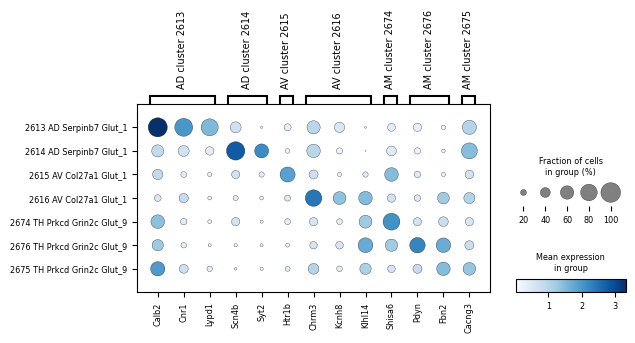

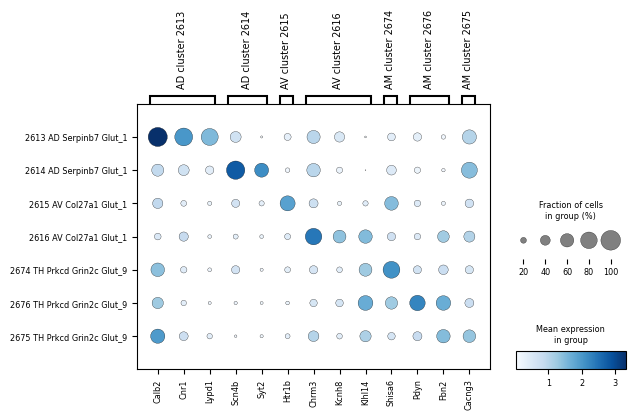

In [40]:
markers_custom_ATN = ['Calb2', 'Cnr1', 'Lypd1',     # ADm 2613
                      'Scn4b', 'Syt2',              # ADl 2614
                      'Htr1b',                      # AVm 2615
                      'Chrm3', 'Kcnh8', 'Klhl14',   # AVl 2616
                      'Shisa6',                     # AM 2674
                      'Pdyn', 'Fbn2',               # AM 2676
                      'Cacng3',                     # AM 2675
                      ]                             

var_group_positions = [
                        [0,2], 
                        [3,4], 
                        [5,5], 
                        [6,8], 
                        [9,9], 
                        [10,11], 
                        [12,12],
                       ]

var_group_labels = ['AD cluster 2613',
                    'AD cluster 2614',
                    'AV cluster 2615',
                    'AV cluster 2616',
                    'AM cluster 2674',
                    'AM cluster 2676',
                    'AM cluster 2675',
                    ]

fig_curated = sc.pl.dotplot(adata_ATN,
                            markers_custom_ATN,
                            groupby='cluster', 
                            dendrogram=False,
                            cmap='Blues', #cc.cm.blues,
                            var_group_positions=var_group_positions,
                            var_group_labels=var_group_labels,
                            var_group_rotation=90,
                            return_fig=True,
                            )
fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN.pdf',
                    transparent=True, bbox_inches='tight')
fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN_colorcetBlues.png',
                    transparent=True, bbox_inches='tight')

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


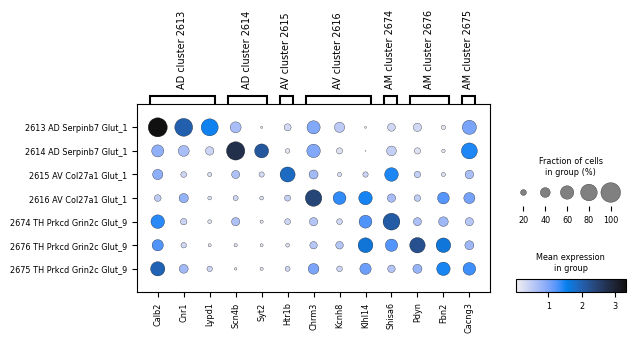

In [32]:
fig_curated = sc.pl.dotplot(adata_ATN,
                            markers_custom_ATN,
                            groupby='cluster', 
                            dendrogram=False,
                            cmap=cc.cm.CET_CBL3_r,
                            var_group_positions=var_group_positions,
                            var_group_labels=var_group_labels,
                            var_group_rotation=90,
                            return_fig=True,
                            )
# fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN.pdf',
#                     transparent=True, bbox_inches='tight')
fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN_colorcetCET_CBL3.png',
                    transparent=True, bbox_inches='tight')

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


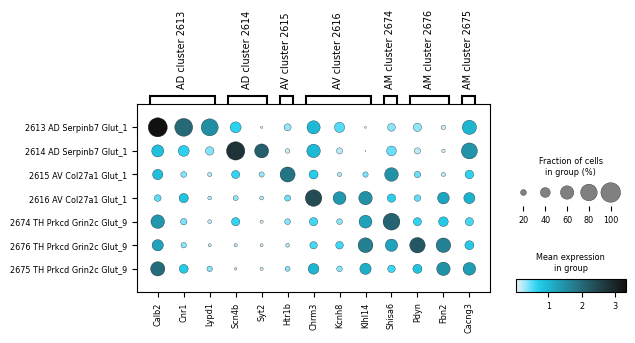

In [34]:
fig_curated = sc.pl.dotplot(adata_ATN,
                            markers_custom_ATN,
                            groupby='cluster', 
                            dendrogram=False,
                            cmap=cc.cm.CET_CBTL3_r,
                            var_group_positions=var_group_positions,
                            var_group_labels=var_group_labels,
                            var_group_rotation=90,
                            return_fig=True,
                            )

fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN_colorcetCBTL3.png',
                    transparent=True, bbox_inches='tight')
fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN_colorcetCBTL3.pdf',
                    transparent=True, bbox_inches='tight')

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


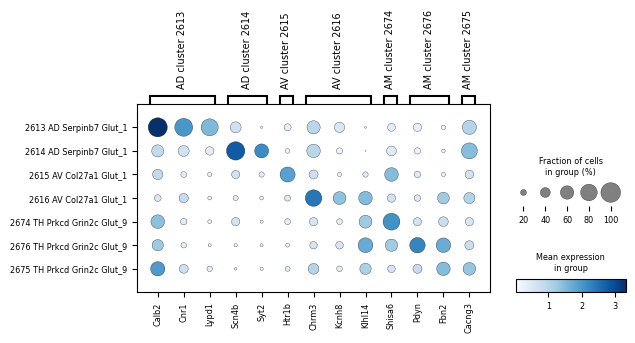

In [35]:
fig_curated = sc.pl.dotplot(adata_ATN,
                            markers_custom_ATN,
                            groupby='cluster', 
                            dendrogram=False,
                            cmap='Blues',
                            var_group_positions=var_group_positions,
                            var_group_labels=var_group_labels,
                            var_group_rotation=90,
                            return_fig=True,
                            )
fig_curated.savefig(f'{results_dir}/degs_curated_dotplot_ATN_matplotlibBlues.png',
                    transparent=True, bbox_inches='tight')

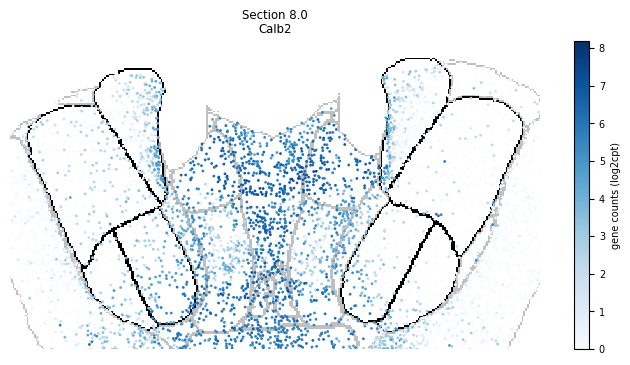

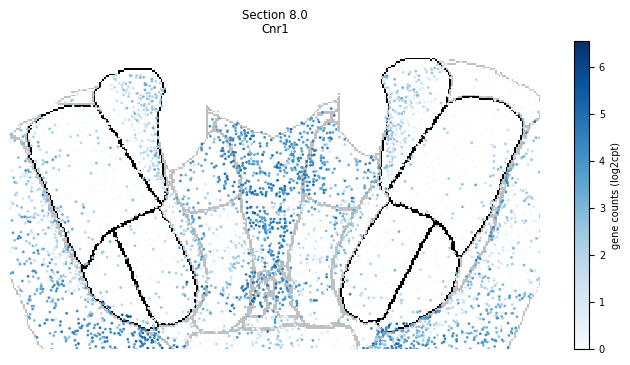

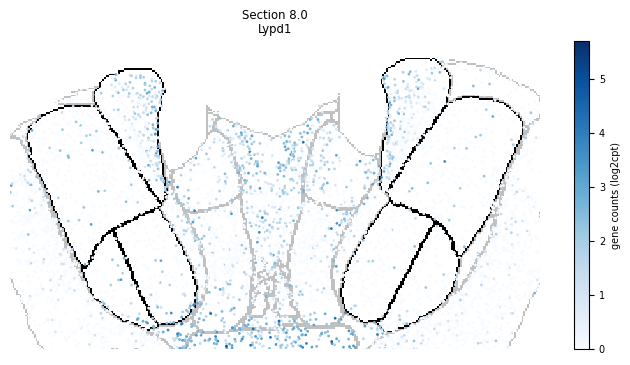

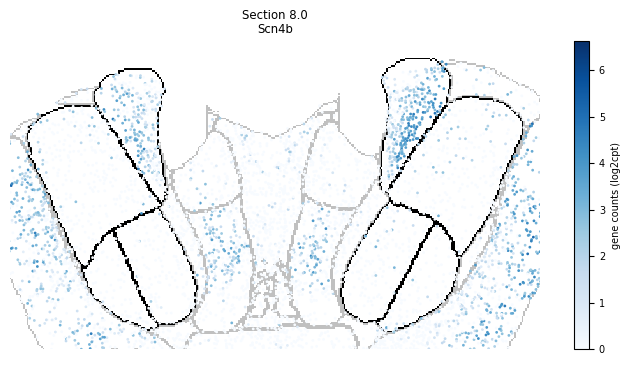

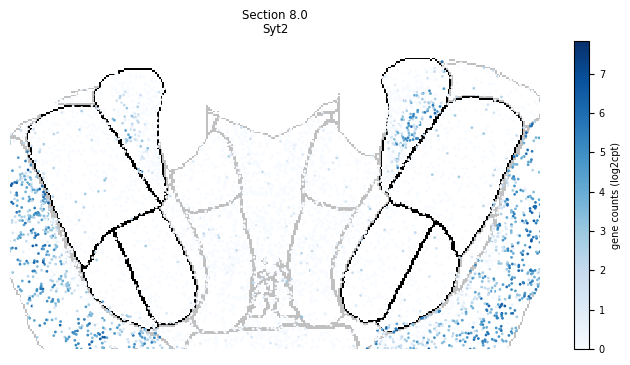

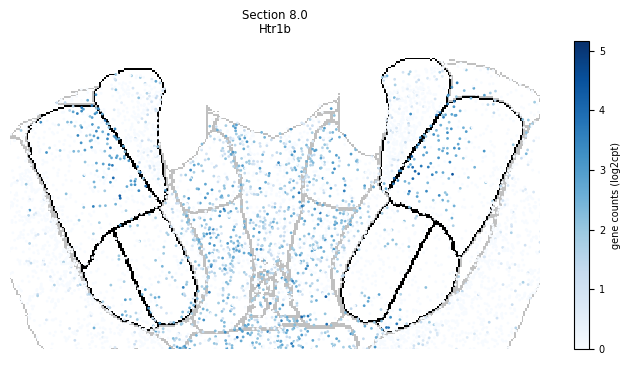

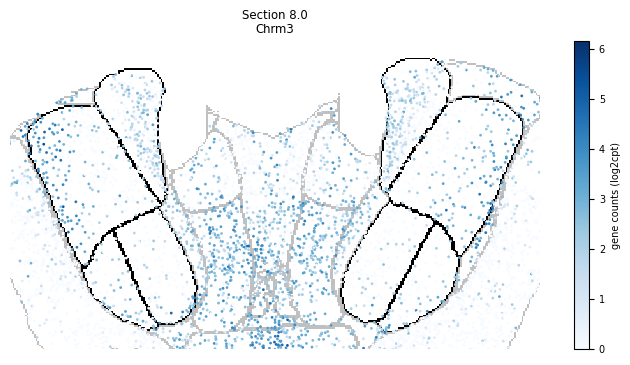

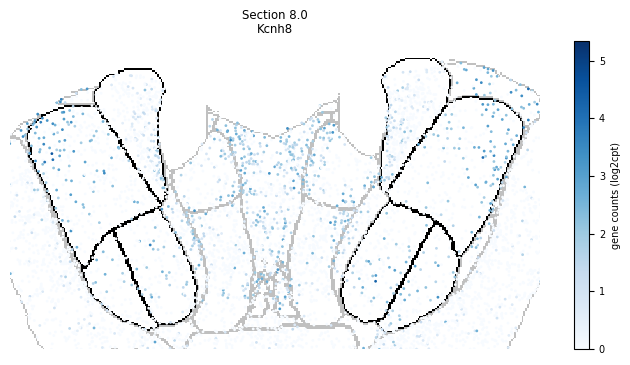

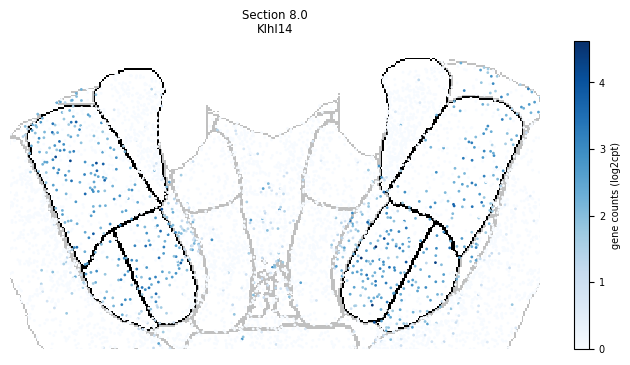

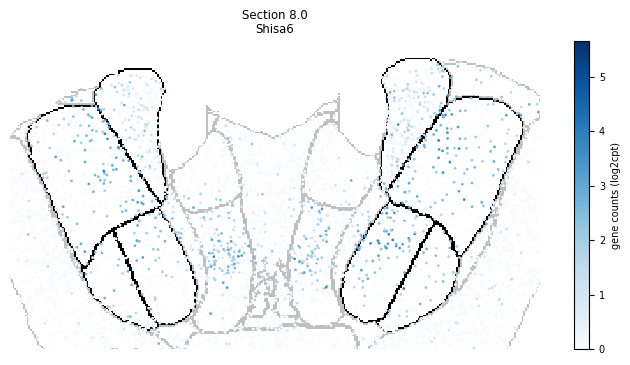

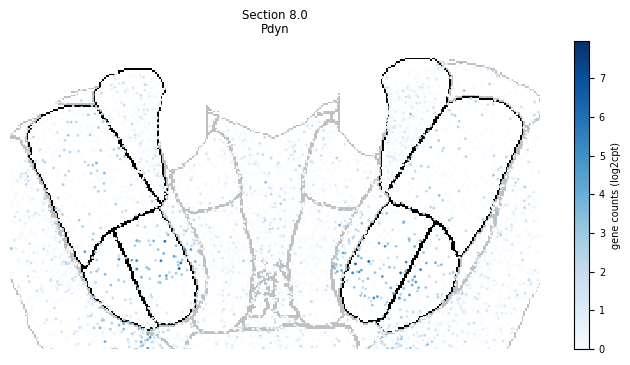

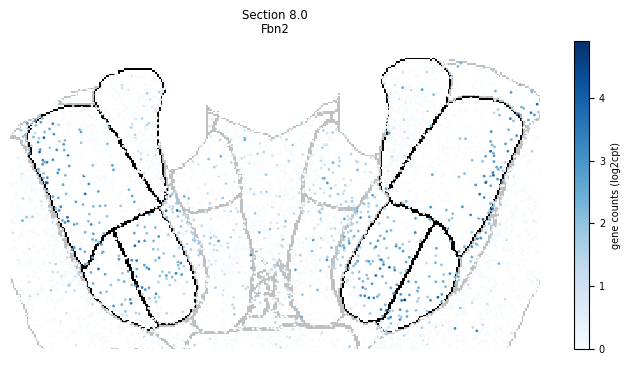

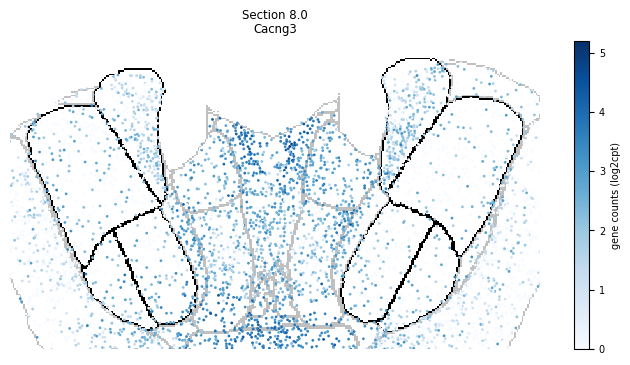

In [36]:
# show outlines for all the ATN
nuclei_ATN = ['AD', 'AV', 'AMd', 'AMv']
sections_ATN = [7.8, 8.0, 8.2]

kwargs_ATN_expr = dict(
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    cmap='Blues',
    point_size=4,
    edge_color='silver'
    )

# we set n_de_genes_to_plot=2 at the top of this notebook
for gene in markers_custom_ATN:
    cplots.plot_expression_ccf(adata_th, 
                               gene, 
                               ccf_images,
                               sections=[8.0],
                               highlight=nuclei_ATN,
                               zoom_to_highlighted=True,
                               **kwargs_ATN_expr)

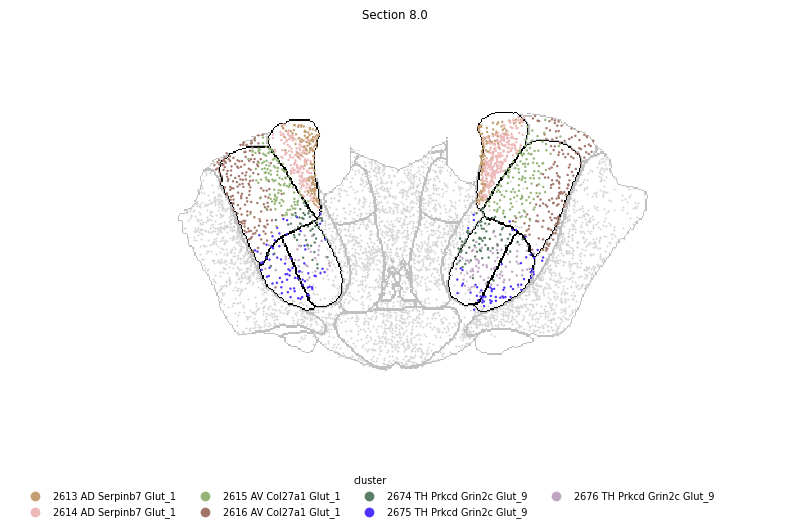

In [37]:
kwargs_cluster_annotations = dict(
    bg_cells=adata_th.obs,
    boundary_img=ccf_boundaries,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=3, #0.5, 
    face_palette=None,
    edge_color='silver'
    )

# Let's look at the cell types in the ATN in one sample section
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV']
taxonomy_level = 'cluster'

figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                    ccf_images, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=[8.0],
                                    point_palette=cluster_palette,
                                    legend='cells',
                                    separate_figs=False, n_rows=1,
                                    figsize=(20,5),#, (8.3, 3),
                                    **kwargs_cluster_annotations)

## MD

In [38]:
markers_MD = ['Scn4b', 'Ldb2', 'Cntnap3', 'Cbln2', 'Cdh20', 'Necab1', 'Tnnt1', 
              'Calb2', 'Drd2']